# Change Point Detection

In [23]:
import os
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from statistics import mean
from tqdm import tqdm
from glob import glob
from scipy import spatial
import csv
from matplotlib import pyplot as plt
import ruptures as rpt
import json
import re

In [2]:
if not os.path.exists('/Users/kawaiyuen/nlpworkshop/concept-creep-chi/3_output/changepoint_detection'):
    os.mkdir('/Users/kawaiyuen/nlpworkshop/concept-creep-chi/3_output/changepoint_detection')

## Load pre-trained diachronic embeddings

In [24]:
pathtomodels = '/Users/kawaiyuen/nlpworkshop/concept-creep-chi_raw/models_aligned'
allmodels = sorted(glob(f'{pathtomodels}/pd_*.model'))

# Load the model for the most recent time slice
lastmodel = Word2Vec.load(allmodels[-1])

# Get the 'name' of each time slice (retrieved from the name of the model)
years = []
for i in range(len(allmodels)):
    year = re.sub(r'pd_(\d+)', r'\1', allmodels[i].split('/')[-1].split('.model')[0])
    years.append(year)

## Define words to analyse

In [10]:
with open('/Users/kawaiyuen/nlpworkshop/concept-creep-chi/0_data/wordlist/concepts.json', 'r') as f:
    concepts_data = json.load(f)

concepts = [concepts_data[key] for key in concepts_data]
concepts = [' '.join(concept) for concept in concepts]
print(concepts)

['偏见', '欺凌', '精神病', '创伤', '分裂', '阴谋', '主权', '恐怖主义']


In [25]:
# Define function for calculating cosine similarity
def cosine_similarity(word,modelx,modely):
  sc = 1-spatial.distance.cosine(modelx.wv[word], modely.wv[word])
  return sc

# Calculate cossim between the vector of the same word in the last time slice and each of the previous time slices
cosmatrix = []
columns = ['timeslice'] + concepts
df = pd.DataFrame(columns=columns)
df['timeslice'] = years
for concept in concepts:
    print(f'Now processing {concept}')
    col = []
    for i in range(len(allmodels)):
        prevmodel = Word2Vec.load(allmodels[i])
        try:
            col.append(cosine_similarity(concept,prevmodel,lastmodel))
        except KeyError:
            col.append('key_not_present')
    df[concept] = col

Now processing 偏见
Now processing 欺凌
Now processing 精神病
Now processing 创伤
Now processing 分裂
Now processing 阴谋
Now processing 主权
Now processing 恐怖主义


In [26]:
df.to_csv('../3_output/changepoint_detection/compare_cosine_change.csv',index=False)

In [49]:
df_spline = df.replace('key_not_present', np.nan)  

# Perform spline interpolation for each concept column
for concept in concepts:
    df_spline[concept] = df_spline[concept].interpolate(method='spline', order=3)

df_spline = df_spline.replace(np.nan, 'key_not_present')  

df_spline.to_csv('../3_output/changepoint_detection/compare_cosine_change_imputated.csv',index=False)

## Compare semantic change trajectory of individual words

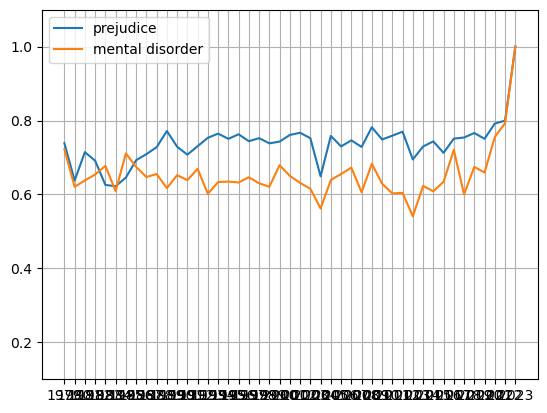

In [50]:
plt.plot(df_spline['timeslice'],df_spline['偏见'],label='prejudice')
plt.plot(df_spline['timeslice'],df_spline['精神病'],label='mental disorder')
# plt.plot(file['decade'],file['gear'],label='gear')
plt.ylim([0.1,1.1])
plt.legend()
plt.grid()
# plt.savefig('./outputs/railwaytraffic.png')

## Detect changepoints

In [51]:
costfunction = 'l1' # Try also 'l2' and 'rbf'
jump = 1
pen = 0.2

In [52]:
slices = df_spline['timeslice']
changepoints = []

for concept in concepts:
    ts = df_spline[concept]
    y = np.array(ts.tolist())
    model = rpt.Pelt(model=costfunction,jump=jump)
    model.fit(y)
    breaks = model.predict(pen=pen)
    print(breaks)
    breaksstr = ''
    for b in breaks:
        if b == len(slices):
            continue
        else:
            breaksstr += str(slices[b-1])
            breaksstr += ' '
    changepoints.append(breaksstr)

changepointsdict = {'concepts': concepts, 'changepoints': changepoints}
changepointsdf = pd.DataFrame.from_dict(changepointsdict)

changepointsdf.to_csv(f'../3_output/changepoint_detection/changepoints-{costfunction}-jump{str(jump)}-pen{str(pen)}.csv',index=False)

[9, 45]
[9, 36, 45]
[42, 45]
[5, 34, 45]
[42, 45]
[34, 45]
[40, 45]
[8, 45]


## Visualize each of the words' trajectories and the detected changepoints

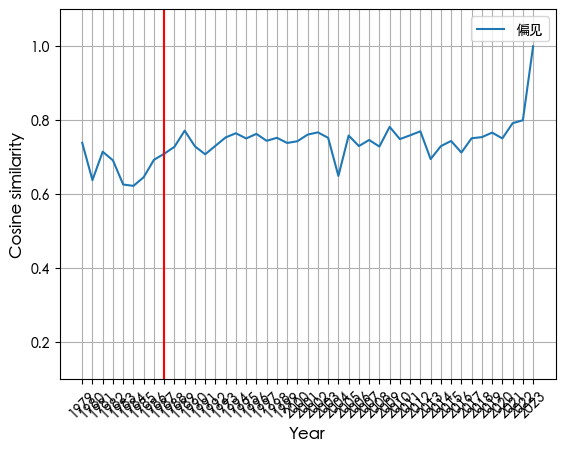

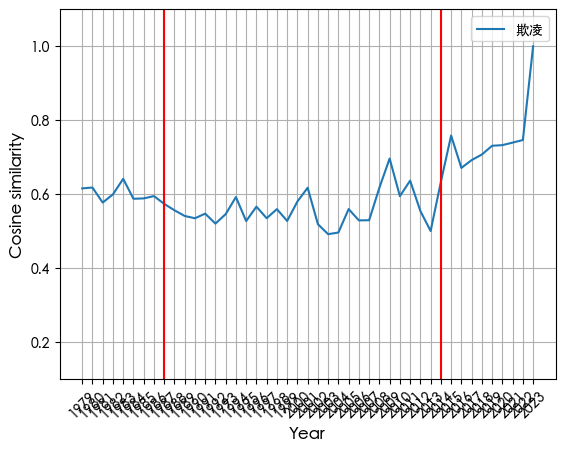

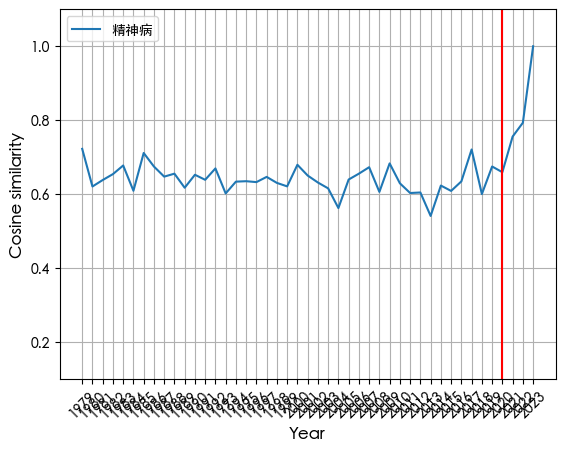

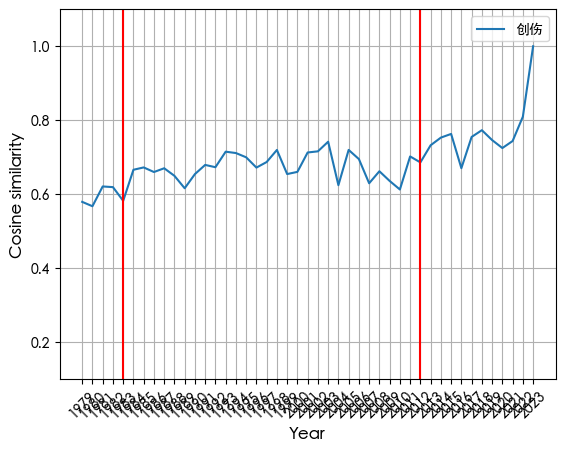

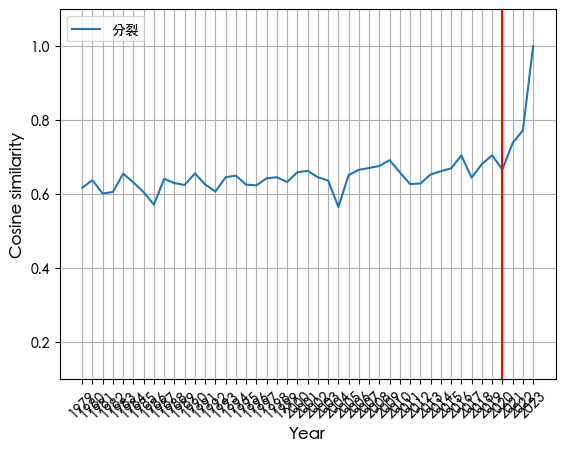

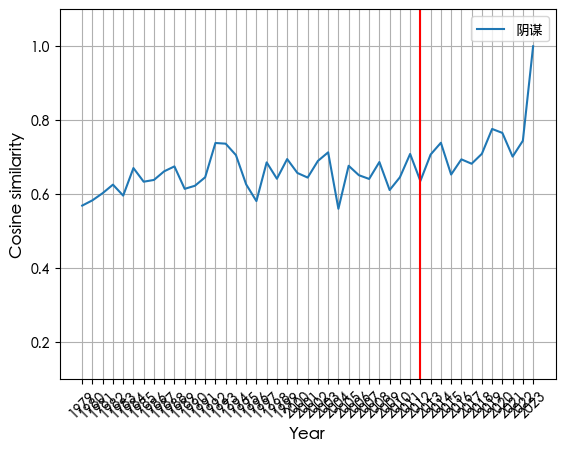

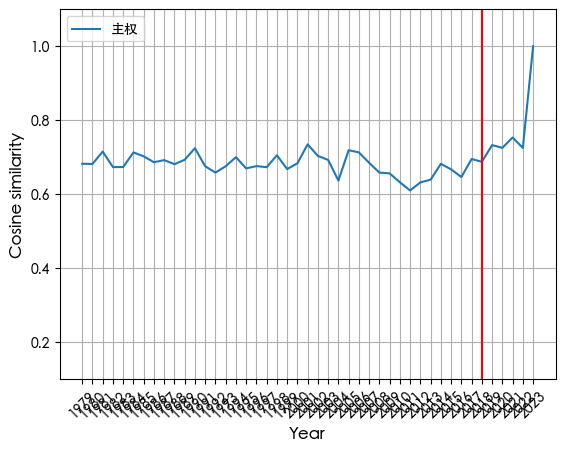

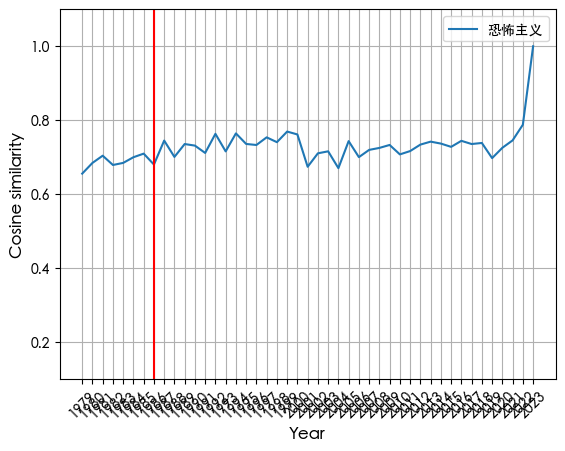

In [54]:
for index, row in changepointsdf.iterrows():
    plt.rcParams['font.family'] = ['Heiti TC']
    plt.plot(df_spline['timeslice'],df_spline[row['concepts']],label=row['concepts'])
    plt.ylim([0.1,1.1])
    plt.xlabel('Year',fontsize=12)
    plt.ylabel('Cosine similarity',fontsize=12)
    for point in row['changepoints'].split():
        plt.axvline(x = point, color = 'r')
    plt.legend()
    plt.grid()
    plt.xticks(rotation = 45)
    plt.show()